# CIFAR-10 Dataset Visualization and Check

This notebook:
- Verifies class balance
- Visualizes CIFAR-10 dataset splits (train/val/test)

## Setup Environment

In [5]:
LOCAL = True

# if run locally:
if LOCAL:
    DATA_DIR = "/Users/Yang/Desktop/research-model-merge/datasets"
    PROJECT_ROOT = "/Users/Yang/Desktop/research-model-merge"
else:
    # on Colab
    ROOT_DIR = "/content"
    DATA_DIR = "/content/datasets"
    PROJECT_ROOT = "/content"
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_DIR = "drive/MyDrive/research-model_merge"

In [6]:
import os
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights

# Add project root to path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datasets.cifar10 import CIFAR10
from common import eval_model_on_dataset, show_split_samples, show_split_samples_with_predictions

In [7]:
# Check GPU availability and system info
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
    DEVICE = torch.device("cuda")
else:
    print("⚠️ No GPU available! Using CPU.")
    DEVICE = torch.device("cpu")

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.1.2
CUDA available: False
⚠️ No GPU available! Using CPU.


## CIFAR-10 Dataset - View

**Note**: This uses persistent indices from `datasets/cifar10_train_val_indices.npy`
- Training: 98% of original training set (49,000 images)  
- Validation: 2% of original training set (1,000 images)  
- Test: Official CIFAR-10 test set (10,000 images)

⚠️ **Persistent indices ensure consistent splits across all experiments!**

In [8]:
# Check if persistent indices exist
INDICES_FILE = os.path.join(DATA_DIR, 'cifar10_train_val_indices.npy')

print("🔍 Checking for persistent indices...")

if os.path.exists(INDICES_FILE):
    print(f"✅ Found persistent indices: {INDICES_FILE}")
else:
    print(f"❌ Persistent indices not found: {INDICES_FILE}")
    print("   Run: cd datasets && python generate_train_val_indices.py cifar10")

🔍 Checking for persistent indices...
✅ Found persistent indices: /Users/Yang/Desktop/research-model-merge/datasets/cifar10_train_val_indices.npy


In [9]:
print("Creating CIFAR-10 dataset...")

dataset = CIFAR10(
    data_location=DATA_DIR,
    batch_size=8,  # Small batch for visualization
    num_workers=2
)

print(f"✅ Dataset created:")
print(f"   Train split: {len(dataset.train_sampler)} samples")
print(f"   Val split: {len(dataset.val_sampler)} samples")
print(f"   Test split: {len(dataset.test_dataset)} samples")
print(f"   Classnames: {dataset.classnames}")

Creating CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Dataset created:
   Train split: 49000 samples
   Val split: 1000 samples
   Test split: 10000 samples
   Classnames: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
import numpy as np
import pandas as pd

def check_class_balance(dataset, split_name):
    """Check class distribution for a given split"""
    
    # Get the appropriate dataset and indices
    if split_name == "train":
        indices = list(dataset.train_sampler.indices)
        full_dataset = dataset.train_dataset
    elif split_name == "validation":
        indices = list(dataset.val_sampler.indices)
        full_dataset = dataset.val_dataset
    elif split_name == "test":
        indices = list(range(len(dataset.test_dataset)))
        full_dataset = dataset.test_dataset
    else:
        raise ValueError(f"Unknown split: {split_name}")
    
    # Count samples per class
    class_counts = [0] * 10
    for idx in indices:
        _, label = full_dataset[idx]
        class_counts[label] += 1
    
    # Create summary
    print(f"\n{'='*60}")
    print(f"{split_name.upper()} Split - Class Distribution")
    print(f"{'='*60}")
    print(f"Total samples: {len(indices)}")
    print(f"\nPer-class breakdown:")
    
    data = []
    for i, count in enumerate(class_counts):
        class_name = dataset.classnames[i]
        percentage = 100 * count / len(indices)
        data.append({
            'Class': i,
            'Name': class_name,
            'Count': count,
            'Percentage': f"{percentage:.2f}%"
        })
        print(f"  {i}: {class_name:12s} - {count:5d} samples ({percentage:.2f}%)")
    
    # Check balance
    min_count = min(class_counts)
    max_count = max(class_counts)
    balance_ratio = min_count / max_count if max_count > 0 else 0
    
    print(f"\nBalance metrics:")
    print(f"  Min samples: {min_count}")
    print(f"  Max samples: {max_count}")
    print(f"  Balance ratio: {balance_ratio:.3f} (1.0 = perfect balance)")
    
    if balance_ratio >= 0.95:
        print(f"  ✅ Excellent balance!")
    elif balance_ratio >= 0.90:
        print(f"  ✅ Good balance")
    else:
        print(f"  ⚠️  Imbalanced (ratio < 0.90)")
    
    return data

# Check balance for all splits
train_data = check_class_balance(dataset, "train")
val_data = check_class_balance(dataset, "validation")
test_data = check_class_balance(dataset, "test")


TRAIN Split - Class Distribution
Total samples: 49000

Per-class breakdown:
  0: airplane     -  4900 samples (10.00%)
  1: automobile   -  4900 samples (10.00%)
  2: bird         -  4900 samples (10.00%)
  3: cat          -  4900 samples (10.00%)
  4: deer         -  4900 samples (10.00%)
  5: dog          -  4900 samples (10.00%)
  6: frog         -  4900 samples (10.00%)
  7: horse        -  4900 samples (10.00%)
  8: ship         -  4900 samples (10.00%)
  9: truck        -  4900 samples (10.00%)

Balance metrics:
  Min samples: 4900
  Max samples: 4900
  Balance ratio: 1.000 (1.0 = perfect balance)
  ✅ Excellent balance!

VALIDATION Split - Class Distribution
Total samples: 1000

Per-class breakdown:
  0: airplane     -   100 samples (10.00%)
  1: automobile   -   100 samples (10.00%)
  2: bird         -   100 samples (10.00%)
  3: cat          -   100 samples (10.00%)
  4: deer         -   100 samples (10.00%)
  5: dog          -   100 samples (10.00%)
  6: frog         -   100 

### Check Class Balance for Each Split

Check that each split has balanced class distribution

### Visualize Training Split

Fetching 8 samples from train split


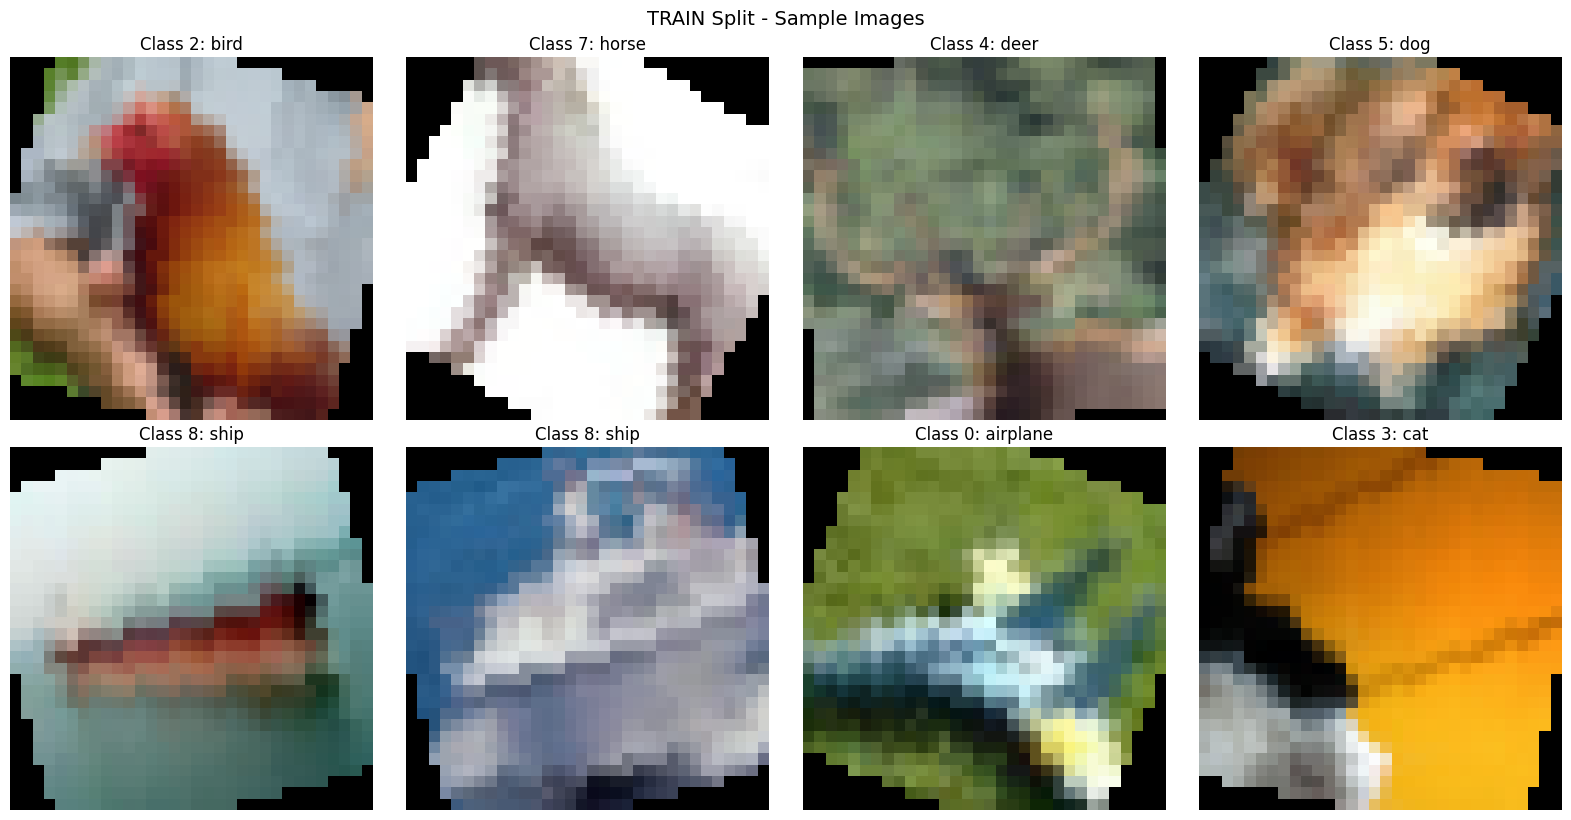

In [11]:
show_split_samples(dataset, "train", batch_index=0)

### Visualize Validation Split

Fetching 8 samples from validation split


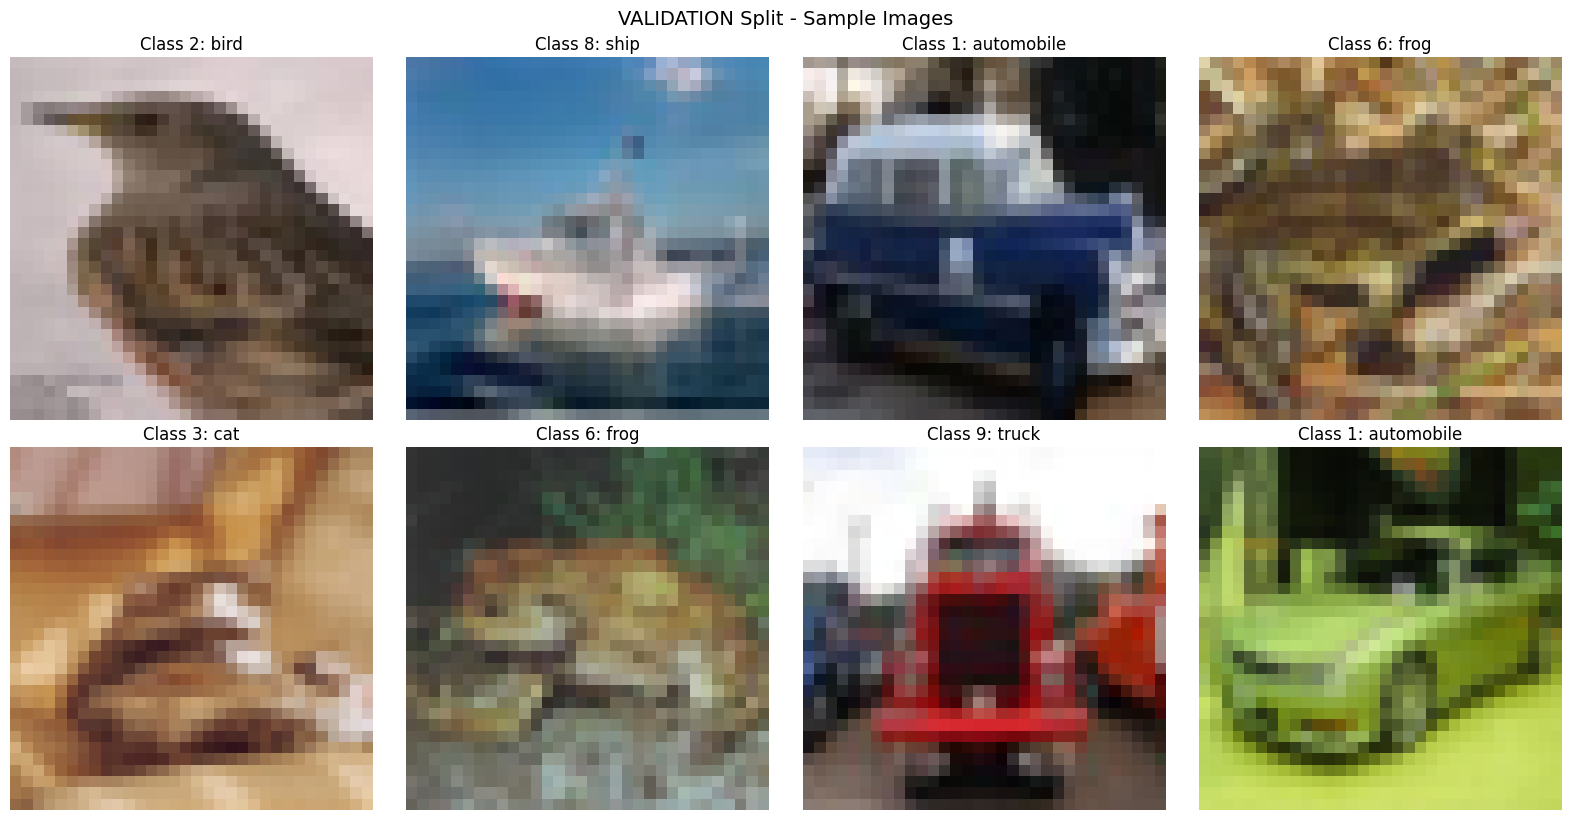

In [12]:
show_split_samples(dataset, "validation", batch_index=0)

### Visualize Test Split

Fetching 8 samples from test split


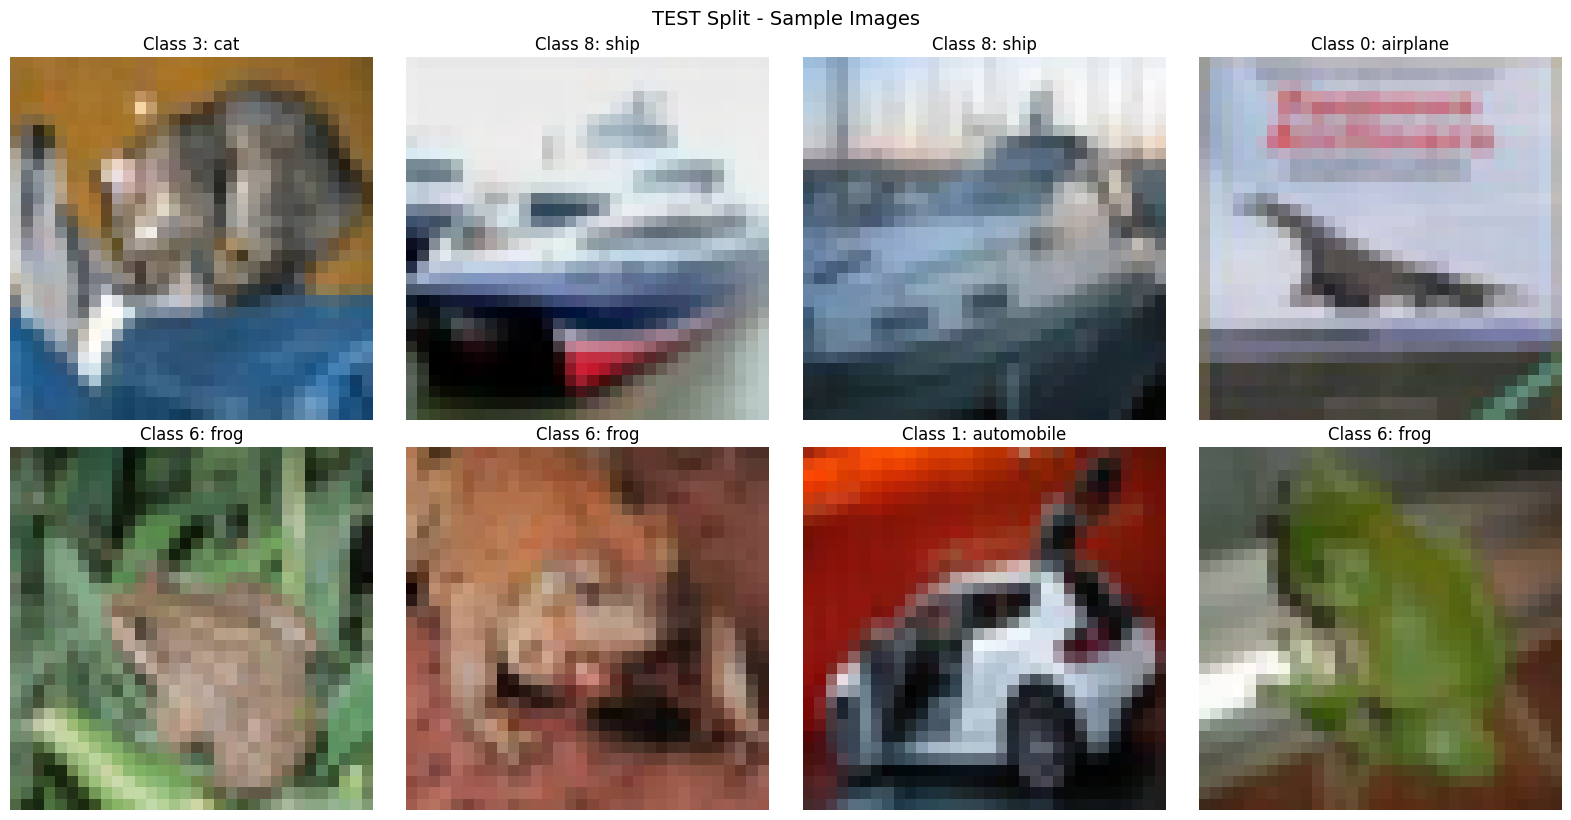

In [13]:
show_split_samples(dataset, "test", batch_index=0)